# Creating a map of street designations

In [1]:
import pandas as pd
from plotnine import *
from geopandas import GeoDataFrame

%matplotlib inline

Load data from shapefile

In [2]:
shp_path = 'gis_osm_roads_free_1.shp'
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4412349,5112,trunk,None,М-10,F,90,0,F,F,"LINESTRING (34.8230332 57.3829918, 34.8263046 ..."
1,4412351,5112,trunk,None,М-10,F,90,0,F,F,"LINESTRING (34.7432594 57.4401731, 34.7453505 ..."
2,4412353,5112,trunk,«Россия»,М-10,F,90,0,F,F,"LINESTRING (34.6612746 57.4975359, 34.6667788 ..."
3,4412397,5141,service,None,None,B,0,0,F,F,"LINESTRING (33.850453 57.8081654, 33.8506119 5..."
4,4418736,5132,trunk_link,None,None,F,0,0,F,F,"LINESTRING (32.1191751 54.7048519, 32.1216124 ..."


Define bounding box

In [3]:
center = [55.75, 37.61]
top = 55.95
bottom = 55.55
left = 37.36
right = 37.86

In [4]:
from shapely.geometry import box
from shapely.geometry import Polygon

bbox = box(left, bottom, right, top)

Create a bounding ellipse for city limits

In [101]:
import folium
import shapely.affinity
from shapely.geometry import Point
import geopy
import geopy.distance

# create an ellipse
radius_lat = geopy.distance.distance(kilometers = 21).destination(point=center, bearing=0)[0] - center[0]
radius_lon = geopy.distance.distance(kilometers = 17).destination(point=center, bearing=90)[1] - center[1]

circle = Point(center[::-1]).buffer(1)
ellipse = shapely.affinity.scale(circle, radius_lon, radius_lat)

ellipse_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

folium.PolyLine(list([c[::-1] for c in ellipse.exterior.coords])).add_to(ellipse_map)

ellipse_map

Select only roads in bounding ellipse

In [6]:
moscow = roads.loc[roads['geometry'].apply(lambda g: ellipse.contains(g))].copy()
moscow.shape

(258019, 11)

Select only roads that have a name or roads that are classified as trunk or primary. Set empty string as name for streets that don't have names.

In [71]:
moscow = moscow[moscow.fclass.isin(['trunk', 'primary']) | moscow['name'].notnull()]
moscow['name'] = moscow['name'].fillna(value='')
moscow.shape

(21611, 14)

Now to define street designations. In Russian, street designations can precede the name (*улица* Пестеля) or follow the name (Малая Грузинская *улица*) or even come in the middle if the street has a number (1-я *улица* Энтузиастов). Let's identify the prefixes and postfixes to find possible street designations.

In [72]:
moscow['prefix'] = moscow['name'].apply(lambda name: name.split(' ')[0] if name is not None else None)
moscow['postfix'] = moscow['name'].apply(lambda name: name.split(' ')[-1] if name is not None else None)

Find designations in street names. I've singled out "вал" (rampart) since many streets carry this designation to remind of old fortification lines.

| Russian | English |
| --- | --- |
| переулок | lane |
| улица | street |
| вал | rampart |
| проезд | drive |
| проспект | avenue |
| шоссе | highway |
| площадь | square |
| набережная | embankment |
| бульвар | boulevard |
| тупик | close |
| магистраль | motorway |

In [73]:
def get_designation(name):
    name = name.lower()
    if 'переулок' in name: return 'переулок'
    elif ' вал' in name: return 'вал'
    elif 'улица' in name: return 'улица'
    elif 'проезд' in name: return 'проезд'
    elif 'проспект' in name: return 'проспект'
    elif 'шоссе' in name: return 'шоссе'
    elif 'площадь' in name: return 'площадь'
    elif 'набережная' in name: return 'набережная'
    elif 'бульвар' in name: return 'бульвар'
    elif 'тупик' in name: return 'тупик'
    elif any(ext in name for ext in ['мкад', 'третье транспортное', 'хорда', 'тоннель', 'путепровод', 'эстакада', 'рокада']):
        return 'магистраль'
    else: return 'остальные'

In [74]:
moscow['designation'] = [get_designation(name) for name in moscow['name']]

In [75]:
moscow.designation.value_counts()

улица         10252
шоссе          2105
проезд         2101
проспект       1544
переулок       1512
остальные      1016
магистраль      918
бульвар         668
площадь         665
набережная      444
вал             270
тупик           116
Name: designation, dtype: int64

In [76]:
moscow.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,prefix,postfix,designation
84,4870954,5115,tertiary,улица Говорова,None,F,0,0,F,F,"LINESTRING (37.3995821 55.7157965, 37.3989483 ...",улица,Говорова,улица
85,4870985,5115,tertiary,Барвихинская улица,None,B,0,0,F,F,"LINESTRING (37.3989483 55.7158174, 37.3969368 ...",Барвихинская,улица,улица
86,4871028,5115,tertiary,улица Толбухина,None,F,0,0,F,F,"LINESTRING (37.3995225 55.7241501, 37.4001193 ...",улица,Толбухина,улица
87,4871099,5115,tertiary,проезд Толбухина,None,B,0,0,F,F,"LINESTRING (37.3970302 55.7175518, 37.3983015 ...",проезд,Толбухина,проезд
90,4871205,5134,secondary_link,Беловежская улица,None,B,0,0,F,F,"LINESTRING (37.4007175 55.7034002, 37.4005129 ...",Беловежская,улица,улица


In [104]:
colors = {
    'улица': '#59c8e5',
    'площадь': '#59c8e5',
    'переулок': '#fed032',
    'тупик': '#fec301',
    'проезд': '#fe4d64',
    'проспект': '#ffb366',
    'шоссе': '#ff9223',
    'магистраль': '#e67300',
    'набережная': '#0a7abf',
    'бульвар': '#4cb580',
    'вал': '#2e968c',
    'остальные': '#cccccc'
}

names_english = {
    'улица': 'street',
    'шоссе': 'highway',
    'проспект': 'avenue',
    'магистраль': 'motorway',
    'набережная': 'embankment',
    'бульвар': 'boulevard',
    'переулок': 'lane',
    'тупик': 'close',
    'площадь': 'square',    
    'вал': 'rampart',
    'проезд': 'drive',
    'остальные': 'others'
}

Create a plot using Matplotlib and save as png (Russian and English versions).

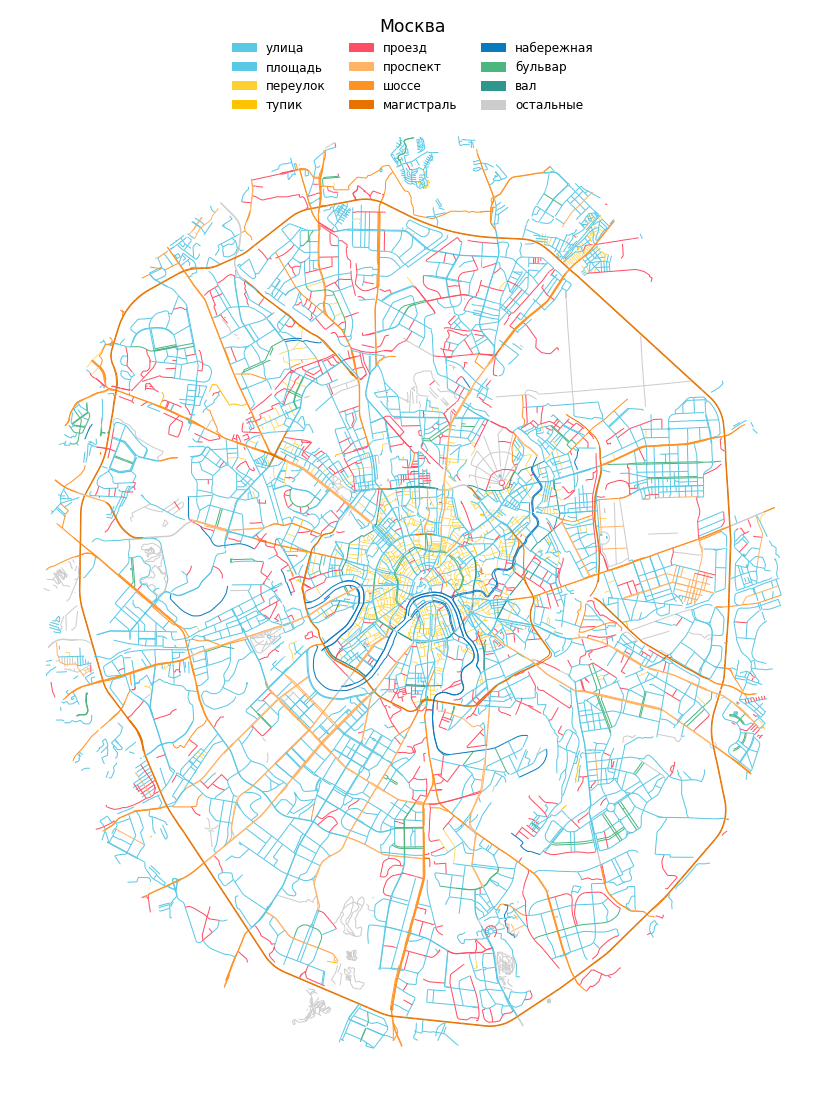

In [105]:
import math
import matplotlib.pyplot as plt
import numpy as np

f, ax = plt.subplots(1, figsize=(20, 20))

moscow.plot(ax=ax,
            color=[colors[d] for d in moscow.designation],
            linewidth=[1 if d != 'переулок' else 0.7 for d in moscow.designation])
ax.set_aspect(1/math.cos(math.pi/180*center[0]))
ax.set_ylim(top=top+0.04)

plt.axis('off')

import matplotlib.patches as mpatches

legend = plt.legend(handles=[mpatches.Patch(color=colors[k], label=k) for k in colors],
                    loc='upper center',
                    fontsize='large',
                    edgecolor='none',
                    title='Москва',
                    title_fontsize='xx-large',
                    ncol=3)

plt.savefig('images/moscow_russian.png', bbox_inches='tight', dpi=300)

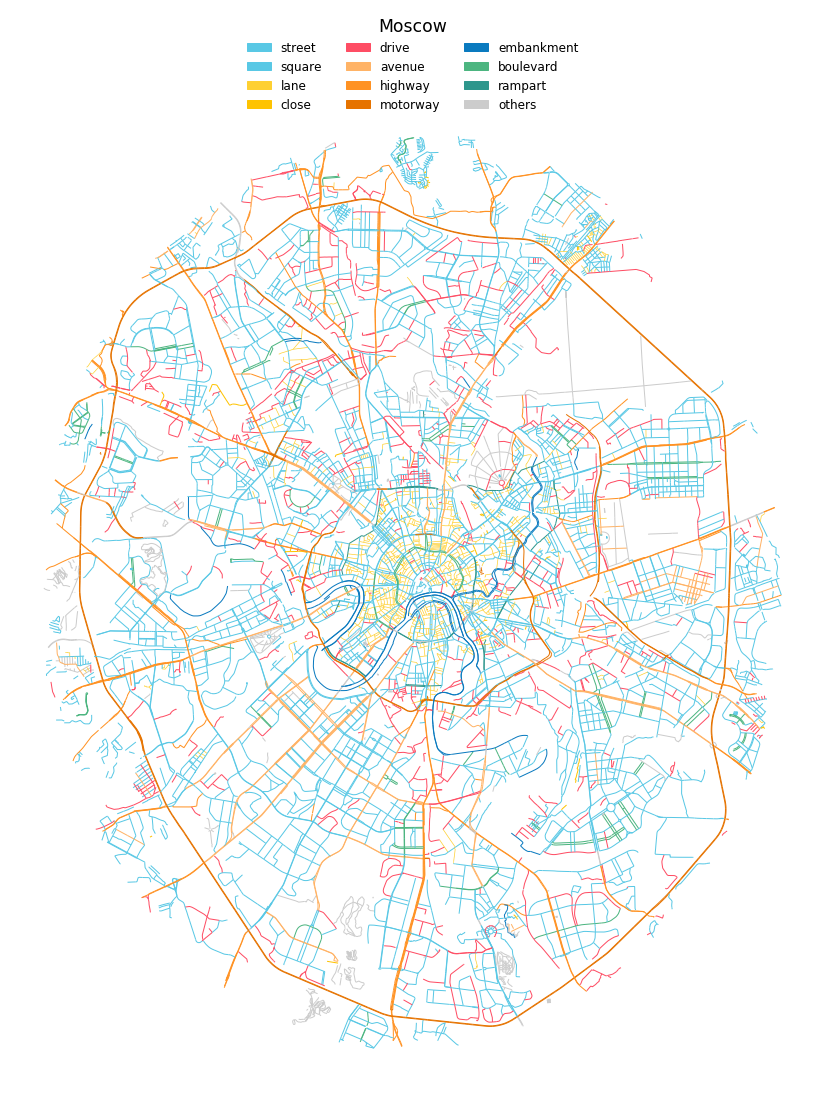

In [106]:
f, ax = plt.subplots(1, figsize=(20, 20))

moscow.plot(ax=ax,
            color=[colors[d] for d in moscow.designation],
            linewidth=[1 if d != 'переулок' else 0.7 for d in moscow.designation])
ax.set_aspect(1/math.cos(math.pi/180*center[0]))
ax.set_ylim(top=top+0.04)

plt.axis('off')

import matplotlib.patches as mpatches

legend = plt.legend(handles=[mpatches.Patch(color=colors[k], label=f'{names_english[k]}') for k in colors],
                    loc='upper center',
                    fontsize='large',
                    edgecolor='none',
                    title='Moscow',
                    title_fontsize='xx-large',
                    ncol=3)

plt.savefig('images/moscow_english.png', bbox_inches='tight', dpi=300)

Create interactive map with Folium

In [107]:
streets_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

for i, street in moscow.iterrows():
    weight = 2
    if 'переулок' in street['name']:
        weight = 1    
    folium.PolyLine(
        [c[::-1] for c in street.geometry.coords],
        color=colors[street['designation']],
        popup=street['name'],
        weight=weight
        ).add_to(streets_map)

streets_map.save('moscow/index.html')